# Final model

### Import modules

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Splitting dataset in training set and test set
from sklearn.model_selection import train_test_split

# For the data preparation before training the model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Model selection and CV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score, make_scorer, cohen_kappa_score, precision_recall_curve, log_loss
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

# To create a LogReg classifier
from sklearn.linear_model import LogisticRegression

import io
from google.colab import files
import random
import math

### Load dataset

In [ ]:
# Training set
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['train_set_mice.csv']))
train_set = pd.DataFrame(data=data)

Saving train_set_mice.csv to train_set_mice (4).csv


In [ ]:
# Test set
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['test_set_mice.csv']))
test_set = pd.DataFrame(data=data)

Saving test_set_mice.csv to test_set_mice (5).csv


### Dataset preparation

We drop the variables 'R_AB', 'NA_R', 'NOT_NA' that are the ones related to the days succesive to the admission to the hospital. We will make use of them at the end, adding them to our model in order to evaluate if and how the results we obtain change.

In [ ]:
X_train = train_set.drop(['Unnamed: 0', 'R_AB', 'NA_R', 'NOT_NA', 'Target'],
                         axis=1)
y_train = train_set.Target

X_test = test_set.drop(['Unnamed: 0', 'R_AB', 'NA_R', 'NOT_NA', 'Target'],
                       axis=1)
y_test = test_set.Target

In [ ]:
random.seed(562023) # set random seed for reproducibility

## Logistic regression classifier

In this section, we build a logistic regression classifier giving as imputs all the features of the cleaned dataframe. We try to reduce the dimensionality adding some penalty in the model.

### Model training

In this subsection, we train our logistic regression model with no penalty.

In [ ]:
# Model instance
log_reg = LogisticRegression(penalty=None, random_state=0, max_iter=10000)

In [ ]:
# Fitting the model on the train set
log_reg.fit(X_train,y_train)

LogisticRegression(max_iter=10000, penalty=None, random_state=0)

Here we perform the model evaluation via cross-validation.

In [ ]:
# Accuracy
scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="accuracy")
print("Accuracy of the model (on the training set): ", scores.mean())

# F1
scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="f1")
print("F1 of the model (on the training set): ", scores.mean())

# Recall (sensitivity)
scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="recall")
print("Recall of the model (on the training set): ", scores.mean())

# Precision
scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="precision")
print("Precision of the model (on the training set): ", scores.mean())

Accuracy of the model (on the training set):  0.8247402870353688
F1 of the model (on the training set):  0.8295160967592026
Recall of the model (on the training set):  0.8499044433827043
Precision of the model (on the training set):  0.8118733617484993


### Hyperparameters tuning

We aim at adding an L1 (Lasso) penalty to our logistic regression model. With this type of regularization, we will eliminate the collinearity between variables and perfom feature selection.

We define our performance index, that we call Measure of Performance (MoP). From now on we will use this calibrated measure to evaluate the performance of our models and make decisions regard them.

In [ ]:
def MoPfun(y_true, y_pred):
  confmat = confusion_matrix(y_true, y_pred)
  total = sum(sum(confmat))
  accuracy = (confmat[0,0] + confmat[1,1]) / total
  sensitivity = confmat[1,1] / (confmat[1,0] + confmat[1,1])
  specificity = confmat[0,0] / (confmat[0,0] + confmat[0,1])
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
  MoP = accuracy*0.3+sensitivity*0.4+precision*0.3
  MoP = sensitivity*0.5+precision*0.3+specificity*0.2

  return MoP


Now we perform a grid search over a reasonable values for the C parameter, in order to choose the optimal one, via cross-validation, that is the one that maximizes the MoP.
We look over the values from 0.01 to 0.5 since we want to perform feature selection and with higher values of C, that results in lower values of lambda, we would't be able to shrink to 0 enough coefficients.

In [ ]:
grid = np.arange(0.01,0.5,0.001)
param = {'C':grid}
log_reg_best = GridSearchCV(LogisticRegression(penalty='l1', random_state=0,
                                               solver='liblinear', max_iter=1000),
                            param, scoring=make_scorer(MoPfun))
log_reg_best.fit(X_train, y_train)

<ipython-input-12-618c3fdb1024>:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
<ipython-input-12-618c3fdb1024>:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
<ipython-input-12-618c3fdb1024>:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
<ipython-input-12-618c3fdb1024>:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
<ipython-input-12-618c3fdb1024>:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
<ipython-input-12-618c3fdb1024>:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
<ipython-input-12-618c3fdb1024>:7: RuntimeWarning: invalid value encountered in long_sca

GridSearchCV(estimator=LogisticRegression(max_iter=1000, penalty='l1',
                                          random_state=0, solver='liblinear'),
             param_grid={'C': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047...
       0.442, 0.443, 0.444, 0.445, 0.446, 0.447, 0.448, 0.449, 0.45 ,
       0.451, 0.452, 0.453, 0.454, 0.455, 0.456, 0.457, 0.458, 0.459,
       0.46 , 0.461, 0.462, 0.463, 0.464, 0.465, 0.466, 0.467, 0.468,
       0.469, 0.47 , 0.471, 0.472, 0.473, 0.474, 0.475, 0.476, 0.477,
       0.478, 0.479, 0.48 , 0.481, 0.482, 0.483, 0.484, 0.485, 0.486,
       0.487, 0.488, 0.489, 0.49 , 0.491, 0.492, 0.493, 0.494, 0.495,
       0.496, 0.497, 0.498, 0.499])},
             scoring=make_scorer(MoPfun))

In [ ]:
# Print best parameter
print("Best parameter of the model: ", log_reg_best.best_params_)

Best parameter of the model:  {'C': 0.4929999999999996}


We plot the mean values of the scores obtained performing the cross-validation with respect to the different parameters of C explored in the grid search.

(0.01, 0.4989999999999996)

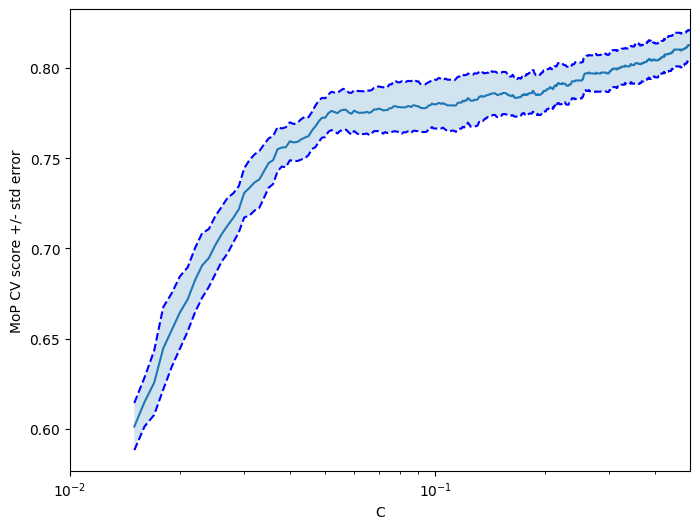

In [ ]:
param_values = log_reg_best.cv_results_['param_C']
scores_mean = log_reg_best.cv_results_['mean_test_score']
scores_std = log_reg_best.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(grid, scores_mean)

n_folds = 5

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(grid, scores_mean + std_error, "b--")
plt.semilogx(grid, scores_mean - std_error, "b--")

plt.fill_between(grid, scores_mean + std_error, scores_mean - std_error, alpha=0.2)

plt.ylabel("MoP CV score +/- std error")
plt.xlabel("C")
plt.axhline(np.max(scores_mean), linestyle="--", color=".5")
plt.xlim([grid[0], grid[-1]])

We extract from the plot the "elbow value".

In [ ]:
target_y = 0.78
interpolated_x = np.interp(target_y, scores_mean, grid)
print(interpolated_x)

0.10101414703744514


We construct our final model using C=0.1.

In [ ]:
interpolated_x = 0.1

In [ ]:
log_reg_best = LogisticRegression(penalty='l1', random_state=0,
                                  solver='liblinear', max_iter=1000,
                                  C=0.1)
log_reg_best.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=0,
                   solver='liblinear')

In [ ]:
# check number of features survived after the feature selection
print(X_train.shape[1]-sum(sum(log_reg_best.coef_==0)))

28


In [ ]:
# Print coefficients
log_reg_best.coef_

array([[ 1.01898267, -0.57337833,  0.        ,  0.5574248 ,  0.        ,
         0.3770711 ,  0.16820167,  0.        ,  0.21900842,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.18358347,
         0.12327945,  0.        , -0.6074264 ,  0.8363624 ,  0.        ,
         0.        ,  0.        , -1.14586974, -0.25886849,  0.        ,
         0.14951697,  0.56033526,  0.        ,  0.        ,  0.        ,
         0.32542066,  0.29623863,  0.        ,  0.        ,  0.42850787,
        -0.62063964,  0.04672027,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.02202498,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [ ]:
# Extract and download coefficients for future interpretation
coefDataFrame = pd.DataFrame(log_reg_best.coef_,columns = X_train.columns)

In [ ]:
coefDataFrame

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,ROE,TIME_B_S,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
0,1.018983,-0.573378,0.0,0.557425,0.0,0.377071,0.168202,0.0,0.219008,0.0,...,0.261629,-0.695975,1.010948,0.0,-0.30559,-0.529469,0.0,-0.673578,0.0,0.0


In [ ]:
coefDataFrame.to_excel('CoefDataFrame.xlsx', encoding = 'utf-8-sig')
files.download('CoefDataFrame.xlsx')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model testing

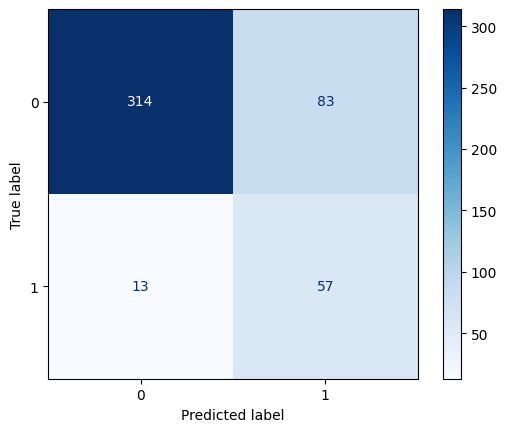

In [ ]:
# Confusion matrix
y_pred = log_reg_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = log_reg_best.classes_)
disp.plot(cmap='Blues')

In [ ]:
# Accuracy
total = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / total
print("Accuracy on the test set: ", accuracy)

# Sensitivity = TP / (TP + FN)
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (fraction of true positive on all positives): ", sensitivity)

# Specificity = TN / (TN + FP)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Specificity (fraction of true negative on all negatives): ", specificity)

# Precision = TP / (TP+FP)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Precision (fraction of true positive on all classified positive): ",
      precision)

# MoP = sensitivity*0.5+precision*0.3+specificity*0.2
MoP = sensitivity*0.5+precision*0.3+specificity*0.2
print("MoP (sensitivity*0.5+precision*0.3+specificity*0.2): ", MoP)

# Cohen_kappa score (accuracy for imbalanced classes)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen_kappa score (accuracy for imbalanced classes): ", cohen_kappa)

Accuracy on the test set:  0.7944325481798715
Sensitivity (fraction of true positive on all positives):  0.8142857142857143
Specificity (fraction of true negative on all negatives):  0.7909319899244333
Precision (fraction of true positive on all classified positive):  0.40714285714285714
MoP (sensitivity*0.5+precision*0.3+specificity*0.2):  0.6874721122706009
Cohen_kappa score (accuracy for imbalanced classes):  0.42867337836115704


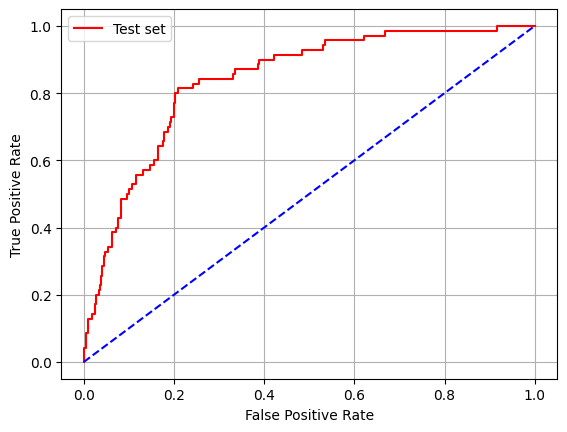

In [ ]:
# ROC curve function
fpr, tpr, thresholds = roc_curve(y_test, log_reg_best.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, 'r-', label='Test set')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# AUC = area under the ROC curve
print("AUC for the logistic regression model on the test set: ",
      roc_auc_score(y_test,y_pred))

AUC for the logistic regression model on the test set:  0.8026088521050738


In [ ]:
# AIC = Akaike information criterion
predicted_values = log_reg_best.predict_proba(X_test)[:,]

# Compute the log-likelihood
log_likelihood = -log_loss(y_test, predicted_values)

# Get the number of parameters (including the intercept)
coef = np.count_nonzero(log_reg_best.coef_)
num_params = coef + 1

# Compute the AIC
aic = -2 * log_likelihood + 2 * num_params
print("AIC:", aic)

AIC: 59.02337969849714


## Choosing the optimal treshold

Here we evaluate if we can achieve better results for sensitivity changing the value of the treshold that normalizes the assignment to class 1 or 0.

In [ ]:
# Optimal treshold selected automatically from ROC curve
optimal_threshold = thresholds[np.argmax(tpr+(1-fpr))]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.5038532105836042


Choosing the treshold automatically from ROC curve we basically obtain the default value, that is 0.5.

We test the model with the optimal treshold.

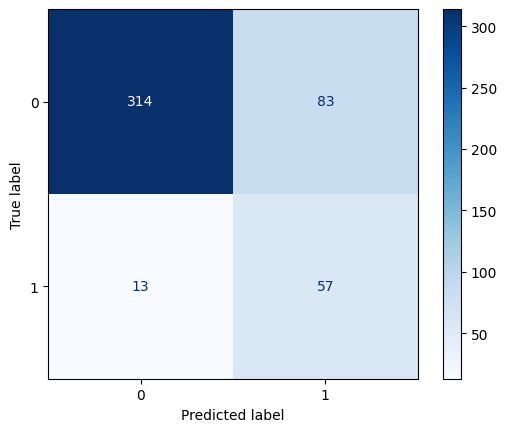

In [ ]:
predicted_values = log_reg_best.predict_proba(X_test)[:, 1]
predicted_values = log_reg_best.predict(X_test)
predicted_class = np.zeros(predicted_values.shape)
predicted_class[predicted_values > optimal_threshold] = 1 # here we change the
                                                          # treshold
y_pred = predicted_class
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = log_reg_best.classes_)
disp.plot(cmap='Blues')

In [ ]:
# Accuracy
total = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / total
print("Accuracy on the test set: ", accuracy)

# Sensitivity = TP / (TP + FN)
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (fraction of true positive on all positives): ", sensitivity)

# Specificity = TN / (TN + FP)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Specificity (fraction of true negative on all negatives): ", specificity)

# Precision = TP / (TP+FP)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Precision (fraction of true positive on all classified positive): ", precision)

# MoP = sensitivity*0.5+precision*0.3+specificity*0.2
MoP = sensitivity*0.5+precision*0.3+specificity*0.2
print("MoP (sensitivity*0.5+precision*0.3+specificity*0.2): ", MoP)

Accuracy on the test set:  0.7944325481798715
Sensitivity (fraction of true positive on all positives):  0.8142857142857143
Specificity (fraction of true negative on all negatives):  0.7909319899244333
Precision (fraction of true positive on all classified positive):  0.40714285714285714
MoP (sensitivity*0.5+precision*0.3+specificity*0.2):  0.6874721122706009


As expected, the results on the test set don't change.

We try to do the same assigning more weight to sensitivity than specificity.

In [ ]:
# Optimal trehold selected automatically from ROC curve
optimal_threshold = thresholds[np.argmax(0.7+tpr+0.3*(1-fpr))]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.2762693098949773


We test the model with the optimal treshold.

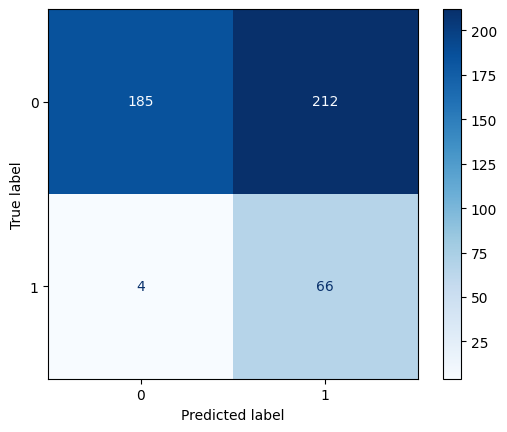

In [ ]:
predicted_values = log_reg_best.predict_proba(X_test)[:, 1]
predicted_class = np.zeros(predicted_values.shape)
predicted_class[predicted_values > optimal_threshold] = 1
y_pred = predicted_class
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = log_reg_best.classes_)
disp.plot(cmap='Blues')

In [ ]:
# Accuracy
total = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / total
print("Accuracy on the test set: ", accuracy)

# Sensitivity = TP / (TP + FN)
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (fraction of true positive on all positives): ", sensitivity)

# Specificity = TN / (TN + FP)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Specificity (fraction of true negative on all negatives): ", specificity)

# Precision = TP / (TP+FP)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Precision (fraction of true positive on all classified positive): ",
      precision)

# MoP = sensitivity*0.5+precision*0.3+specificity*0.2
MoP = sensitivity*0.5+precision*0.3+specificity*0.2
print("MoP (sensitivity*0.5+precision*0.3+specificity*0.2): ", MoP)

Accuracy on the test set:  0.5374732334047109
Sensitivity (fraction of true positive on all positives):  0.9428571428571428
Specificity (fraction of true negative on all negatives):  0.4659949622166247
Precision (fraction of true positive on all classified positive):  0.23741007194244604
MoP (sensitivity*0.5+precision*0.3+specificity*0.2):  0.6358505854546301


Here, we notice that the results get worse.

Here we choose the optimal treshold using cross-validation, based on our performance index MoP.

In [ ]:
# K-fold CV
K = 5

# Thresholds to determine if a predicted value falls in class 0 or 1
threshold = np.arange(0.1, 0.9, 0.01)

# Extremes of the dataset for the CV
ext = np.linspace(0, X_train.shape[0], K+1).astype(int)

# Metrics
# TP/(TP+FP)
acc = np.zeros(shape=K)
sens = np.zeros(shape=K)
spec = np.zeros(shape=K)
prec = np.zeros(shape=K)
accuracy = np.zeros(shape=len(threshold))
sensitivity = np.zeros(shape=len(threshold))
specificity = np.zeros(shape=len(threshold))
precision = np.zeros(shape=len(threshold))
mop = np.zeros(shape=len(threshold))
MoPMax = 0


In [ ]:
for i in range(0, len(threshold)):
  for k in range(0, K):
    # Training and validation tests
    train = X_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    y_t = y_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    validation = X_train.iloc[ext[k]:ext[k+1]]
    y_val = y_train[ext[k]:ext[k+1]]

    predicted_values = log_reg_best.predict_proba(X_test)[:, 1]
    predicted_class = np.zeros(predicted_values.shape)

    # Predicting values
    predicted_values = log_reg_best.predict_proba(validation)[:, 1]
    predicted_class = np.zeros(predicted_values.shape)
    predicted_class[predicted_values > threshold[i]] = 1

    # Accuracy, sensitivity and specificity for every validation set
    cm = confusion_matrix(y_val, predicted_class)
    total = sum(sum(cm))
    acc[k] = (cm[0,0] + cm[1,1]) / total
    sens[k] = cm[1,1] / (cm[1,1] + cm[1,0])
    spec[k] = cm[0,0] / (cm[0,0] + cm[0,1])
    prec[k] = cm[1,1] / (cm[1,1] + cm[0,1])

  # Accuracy, sensitivity and specificity for the chosen threshold
  accuracy[i] = acc.mean()
  sensitivity[i] = sens.mean()
  specificity[i] = spec.mean()
  precision[i] = prec.mean()
  mop[i] = MoPfun(y_val, predicted_class)
  if (mop[i] > MoPMax): # troviamo la threshold che mi dà la GabriMeas max
    thrMax = threshold[i]
    MoPMax = mop[i]

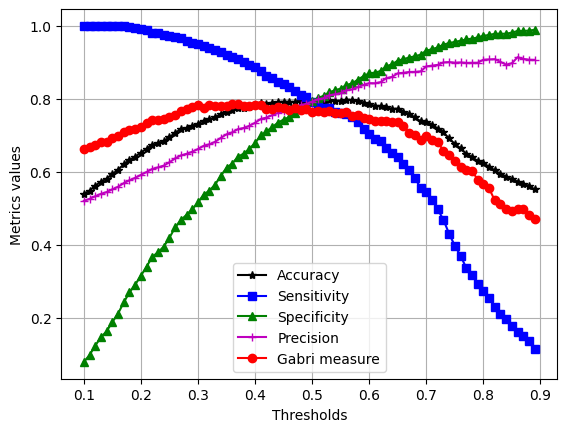

In [ ]:
# Plots
plt.plot(threshold, accuracy, 'k*-', label='Accuracy')
plt.plot(threshold, sensitivity, 'bs-', label='Sensitivity')
plt.plot(threshold, specificity, 'g^-', label='Specificity')
plt.plot(threshold, precision, 'm+-', label='Precision')
plt.plot(threshold, mop, 'ro-', label='Gabri measure')
plt.xlabel('Thresholds')
plt.ylabel('Metrics values')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(MoPMax,thrMax)

0.7870595386695792 0.3699999999999999


We test the model with the optimal treshold.

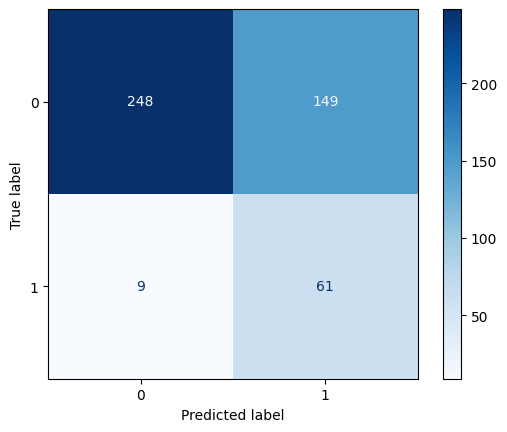

In [ ]:
predicted_values = log_reg_best.predict_proba(X_test)[:, 1]
predicted_class = np.zeros(predicted_values.shape)
predicted_class[predicted_values > thrMax] = 1 # qua cambiamo la threshold come vogliamo!
y_pred = predicted_class
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = log_reg_best.classes_)
disp.plot(cmap='Blues')

In [ ]:
# Accuracy
total = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / total
print("Accuracy on the test set: ", accuracy)

# Sensitivity = TP / (TP + FN)
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (fraction of true positive on all positives): ", sensitivity)

# Specificity = TN / (TN + FP)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Specificity (fraction of true negative on all negatives): ", specificity)

# Precision = TP / (TP+FP)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Precision (fraction of true positive on all classified positive): ", precision)

# MoP = sensitivity*0.5+precision*0.3+specificity*0.2
MoP = sensitivity*0.5+precision*0.3+specificity*0.2
print("MoP (sensitivity*0.5+precision*0.3+specificity*0.2): ", MoP)

Accuracy on the test set:  0.6616702355460385
Sensitivity (fraction of true positive on all positives):  0.8714285714285714
Specificity (fraction of true negative on all negatives):  0.6246851385390428
Precision (fraction of true positive on all classified positive):  0.2904761904761905
MoP (sensitivity*0.5+precision*0.3+specificity*0.2):  0.6477941705649515


Also here the results worsen, we keep as final model the one obtained using the default treshold value, i.e. 0.5.

## Interpretation of results

In [ ]:
# Print again coefficients of final model
log_reg_best.coef_

array([[ 1.01898267, -0.57337833,  0.        ,  0.5574248 ,  0.        ,
         0.3770711 ,  0.16820167,  0.        ,  0.21900842,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.18358347,
         0.12327945,  0.        , -0.6074264 ,  0.8363624 ,  0.        ,
         0.        ,  0.        , -1.14586974, -0.25886849,  0.        ,
         0.14951697,  0.56033526,  0.        ,  0.        ,  0.        ,
         0.32542066,  0.29623863,  0.        ,  0.        ,  0.42850787,
        -0.62063964,  0.04672027,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.02202498,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [ ]:
variable_names = X_train.columns
coef = abs(log_reg_best.coef_[0])

# Create a list of variable names ordered by coefficients (highest first)
sorted_variable_names = [name for _, name in sorted(zip(coef, variable_names), reverse=True)]

In [ ]:
coef

array([1.01898267, 0.57337833, 0.        , 0.5574248 , 0.        ,
       0.3770711 , 0.16820167, 0.        , 0.21900842, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18358347,
       0.12327945, 0.        , 0.6074264 , 0.8363624 , 0.        ,
       0.        , 0.        , 1.14586974, 0.25886849, 0.        ,
       0.14951697, 0.56033526, 0.        , 0.        , 0.        ,
       0.32542066, 0.29623863, 0.        , 0.        , 0.42850787,
       0.62063964, 0.04672027, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02202498, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.88257712, 0.        , 0.        , 0.        , 0.     

In [ ]:
sorted_variable_names[0:X_train.shape[1]-sum(sum(log_reg_best.coef_==0))]

['L_BLOOD',
 'S_AD_ORIT',
 'AGE',
 'NITR_S',
 'n_p_ecg_p_12',
 'zab_leg_02',
 'TIME_B_S',
 'ASP_S_n',
 'ritm_ecg_p_01',
 'zab_leg_01',
 'SEX',
 'MP_TP_POST',
 'STENOK_AN',
 'ANT_CA_S_n',
 'IM_PG_P',
 'IBS_POST',
 'ant_im',
 'B_BLOK_S_n',
 'lat_im',
 'ROE',
 'D_AD_ORIT',
 'DLIT_AG',
 'endocr_01',
 'GB',
 'K_SH_POST',
 'endocr_02',
 'ritm_ecg_p_02',
 'n_r_ecg_p_03']

## Adding successive days variables

We add to our final model the variables related to the days succesive to the admission to the hospital: 'R_AB', 'NA_R', 'NOT_NA' and we evaluate the changes produced, if any.

In [ ]:
# Training set
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['train_set_mice.csv']))
train_set = pd.DataFrame(data=data)

Saving train_set_mice.csv to train_set_mice.csv


In [ ]:
# Test set
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['test_set_mice.csv']))
test_set = pd.DataFrame(data=data)

Saving test_set_mice.csv to test_set_mice.csv


In [ ]:
X_train_new = train_set[['L_BLOOD','S_AD_ORIT','AGE','NITR_S','n_p_ecg_p_12',
                         'zab_leg_02','TIME_B_S','ASP_S_n','ritm_ecg_p_01',
                         'zab_leg_01','SEX','MP_TP_POST','STENOK_AN', 'ANT_CA_S_n',
                         'IM_PG_P','IBS_POST','ant_im','B_BLOK_S_n','lat_im','ROE',
                         'D_AD_ORIT','DLIT_AG','endocr_01','GB','K_SH_POST',
                         'endocr_02','ritm_ecg_p_02', 'n_r_ecg_p_03','R_AB',
                         'NA_R', 'NOT_NA']]
X_test_new = test_set[['L_BLOOD','S_AD_ORIT','AGE','NITR_S','n_p_ecg_p_12',
                         'zab_leg_02','TIME_B_S','ASP_S_n','ritm_ecg_p_01',
                         'zab_leg_01','SEX','MP_TP_POST','STENOK_AN', 'ANT_CA_S_n',
                         'IM_PG_P','IBS_POST','ant_im','B_BLOK_S_n','lat_im','ROE',
                         'D_AD_ORIT','DLIT_AG','endocr_01','GB','K_SH_POST',
                         'endocr_02','ritm_ecg_p_02', 'n_r_ecg_p_03','R_AB',
                         'NA_R', 'NOT_NA']]

In [ ]:
log_reg_best.fit(X_train_new, y_train)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=0,
                   solver='liblinear')

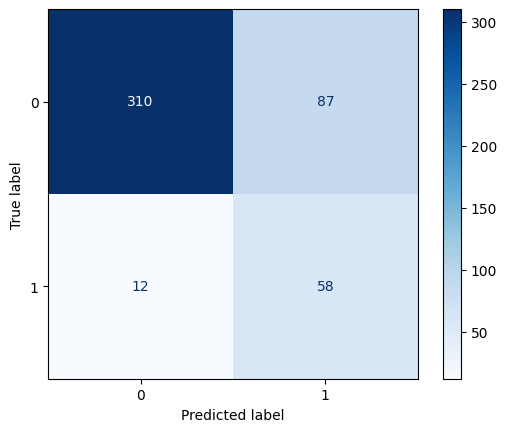

In [ ]:
# Confusion matrix
y_pred = log_reg_best.predict(X_test_new)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = log_reg_best.classes_)
disp.plot(cmap='Blues')

In [ ]:
# Accuracy
total = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / total
print("Accuracy on the test set: ", accuracy)

# Sensitivity = TP / (TP + FN)
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (fraction of true positive on all positives): ", sensitivity)

# Specificity = TN / (TN + FP)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Specificity (fraction of true negative on all negatives): ", specificity)

# Precision = TP / (TP+FP)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Precision (fraction of true positive on all classified positive): ",
      precision)

# MoP = sensitivity*0.5+precision*0.3+specificity*0.2
MoP = sensitivity*0.5+precision*0.3+specificity*0.2
print("MoP (sensitivity*0.5+precision*0.3+specificity*0.2): ", MoP)

# Cohen_kappa score (accuracy for imbalanced classes)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen_kappa score (accuracy for imbalanced classes): ", cohen_kappa)

Accuracy on the test set:  0.7880085653104925
Sensitivity (fraction of true positive on all positives):  0.8285714285714286
Specificity (fraction of true negative on all negatives):  0.7808564231738035
Precision (fraction of true positive on all classified positive):  0.4
MoP (sensitivity*0.5+precision*0.3+specificity*0.2):  0.690456998920475
Cohen_kappa score (accuracy for imbalanced classes):  0.4228450159166094


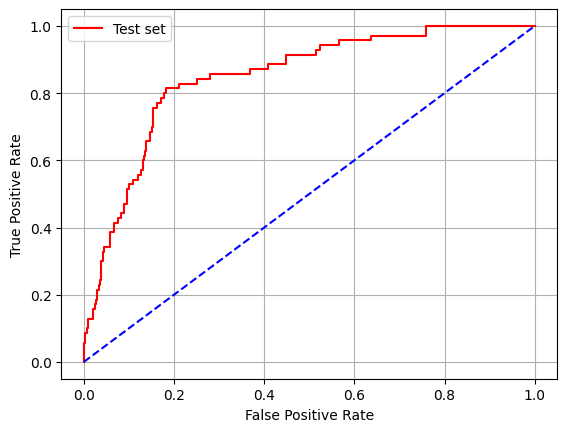

In [ ]:
# ROC curve function
fpr, tpr, thresholds = roc_curve(y_test, log_reg_best.predict_proba(X_test_new)[:,1])
plt.plot(fpr, tpr, 'r-', label='Test set')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# AUC = area under the ROC curve
print("AUC for the logistic regression model on the test set: ", roc_auc_score(y_test,y_pred))

AUC for the logistic regression model on the test set:  0.8047139258726161


In [ ]:
# AIC = Akaike information criterion

log_likelihood = -log_loss(y_test, y_pred)

coef = np.count_nonzero(log_reg_best.coef_)
num_params = coef + 1

aic = -2 * log_likelihood + 2 * num_params
print("AIC:", aic)

AIC: 77.28189158682055


We observe that the results on the test set are substantially the same.